# Modelowania i walidacja

#### Wczytanie bibliotek

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
np.random.seed = 42

In [62]:
# Kod z https://stackoverflow.com/a/49199019 generujący zawartość requiments.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')

imblearn==0.0
matplotlib==3.7.2
numpy==1.24.3
pandas==2.0.3
scikit-learn==1.2.2
seaborn==0.12.2
xgboost==2.0.3


#### Używane funkcje

In [63]:
def handle_outliers(df):
    columns_to_be_checked = ['r', 'u', 'i', 'z', 'g']
    
    df = df[df['u'] > 0]

    for i in range(len(columns_to_be_checked)):
        column = df[columns_to_be_checked[i]]
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (column < lower_bound) | (column > upper_bound)

        outliers_count = outliers.sum()

        outliers_percentage = outliers.mean() * 100
        
        # Zastąpienie outlierów wartościami równymi Q1 - 1.5 * IQR lub Q3 + 1.5 * IQR
        df.loc[outliers, columns_to_be_checked[i]] = np.where(column[outliers] < lower_bound, lower_bound, upper_bound)

        ##print("Ilość outlierów dla kolumny ", columns_to_be_checked[i], ": ", outliers_count)
        ##print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i], ": ", outliers_percentage)

    return df

def modify_data(df):
    
#     df = handle_outliers(df)
    
    df = df.loc[:, df.columns != 'rerun_ID']
    df = df.loc[:, df.columns != 'obj_ID']
    df = df.loc[:, df.columns != 'plate']
    
    df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

    # Normalizacja
    columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
    df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

    # Standaryzacja
    columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
    df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])

    # Usuwanie kolumn
    df = df.drop(['MJD'], axis = 1)
    df = df.drop(['r', 'i', 'z'], axis = 1)

    # Odrzucenie cech na podstawie interpretacji ich znaczenia
    df = df.drop(['spec_obj_ID'], axis = 1) # numer obiektu
    df = df.drop(['alpha'], axis = 1) # współrzędne astronomiczne
    df = df.drop(['delta'], axis = 1) # współrzędne astronomiczne
    df = df.drop(['field_ID'], axis = 1) # numer pola ze zdjęcia (fragment zdjęcia)
    df = df.drop(['cam_col'], axis = 1) # numer kolumny ze zdjęcia (fragment zdjęcia)
    df = df.drop(['run_ID'], axis = 1) # numer zdjęcia
    df = df.drop(['fiber_ID'], axis = 1) # numer włókna, które skierowało światło na płaszczyznę ogniskową
    
    return df

def accuracy_fun(test_target, test_predictions):
    # Dokładność całkowita
    accuracy = accuracy_score(test_target, test_predictions)
    print("Dokładność całkowita (Accuracy):", accuracy)
    return accuracy

def raport(test_target, test_predictions):
    print("\nRaport klasyfikacji:")
    print(classification_report(test_target, test_predictions))

def matrix_confusion(test_target, test_predictions):
    print("\nConfusion matrix:")
    print(confusion_matrix(test_target, test_predictions))


def auc_gini(lb, test_target_bin, proba_predictions, test_target, model):
    auc_scores = []
    for i in range(len(lb.classes_)):
        auc_score = roc_auc_score(test_target_bin[:, i], proba_predictions[:, i])
        auc_scores.append(auc_score)
        print(f"AUC dla klasy {lb.classes_[i]}: {auc_score}")
        print(f"Gini dla klasy {lb.classes_[i]}: {2 * auc_score - 1}")
        print(" ")
        
        fpr, tpr, _ = roc_curve(test_target == model.classes_[i], proba_predictions[:, i])
        plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {auc_score:.2f})')
    
    # Średni AUC
    mean_auc = np.mean(auc_scores)
    print("Średni AUC:", mean_auc)
    
    gini_coefficient = 2 * mean_auc - 1
    print("Gini coefficient:", gini_coefficient)
    return auc_scores, mean_auc, gini_coefficient

def evaluate_model(model, train_df, test_df, wersja=1):
    
    # Dane
    train_target = train_df['class']
    train_data = train_df.drop('class', axis=1)
    test_target = test_df['class']
    test_data = test_df.drop('class', axis=1)
    
    if wersja == 1:

        # Trenowanie modelu
        model.fit(train_data, train_target)

        # Predykcja klas dla danych testowych
        test_predictions = model.predict(test_data)

        # Accuracy
        accuracy = accuracy_fun(test_target, test_predictions)

        # Raport klasyfikacji
        raport(test_target, test_predictions)

        # Macierz pomyłek
        matrix_confusion(test_target, test_predictions)

        proba_predictions = model.predict_proba(test_data)

        # Konwersja etykiet klas na formę binarną dla każdej klasy
        lb = LabelBinarizer()
        lb.fit(train_target)
        test_target_bin = lb.transform(test_target)

        # Obliczenie AUC dla każdej klasy
        auc_gini(lb, test_target_bin, proba_predictions, test_target, model)
    
    if wersja == 2:

        # Zakodowanie etykiet klas jako liczby
        label_encoder = LabelEncoder()
        train_target_encoded = label_encoder.fit_transform(train_target)
        test_target_encoded = label_encoder.transform(test_target)

        # Trenowanie modelu XGBoost
        model.fit(train_data, train_target_encoded)

        # Predykcja klas dla danych testowych
        test_predictions = model.predict(test_data)

        # Accuracy
        accuracy = accuracy_fun(test_target_encoded, test_predictions)

        # Raport klasyfikacji
        raport(test_target_encoded, test_predictions)

        # Macierz pomyłek
        matrix_confusion(test_target_encoded, test_predictions)

        proba_predictions = model.predict_proba(test_data)

        # Obliczenie AUC dla każdej klasy
        auc_scores = []
        for i in range(len(label_encoder.classes_)):
            auc_score = roc_auc_score(test_target_encoded == i, proba_predictions[:, i])
            auc_scores.append(auc_score)
            print(f"AUC dla klasy {label_encoder.classes_[i]}: {auc_score}")
            print(f"Gini dla klasy {label_encoder.classes_[i]}: {2 * auc_score - 1}")
            print(" ")

        # Średni AUC
        mean_auc = np.mean(auc_scores)
        print("Średni AUC:", mean_auc)

        gini_coefficient = 2 * mean_auc - 1
        print("Gini coefficient:", gini_coefficient)
        # Obliczenie AUC dla każdej klasy
        auc_scores = []
        for i in range(len(label_encoder.classes_)):
            auc_score = roc_auc_score(test_target_encoded == i, proba_predictions[:, i])
            auc_scores.append(auc_score)
            print(f"AUC dla klasy {label_encoder.classes_[i]}: {auc_score}")
            print(f"Gini dla klasy {label_encoder.classes_[i]}: {2 * auc_score - 1}")
            print(" ")

        # Średni AUC
        mean_auc = np.mean(auc_scores)
        print("Średni AUC:", mean_auc)

        gini_coefficient = 2 * mean_auc - 1
        print("Gini coefficient:", gini_coefficient)
        
    if wersja == 3:

        # Zakodowanie klas za pomocą OneHotEncoder
        encoder = OneHotEncoder(sparse=False)
        train_target = encoder.fit_transform(train[['class']])
        test_target = encoder.transform(t[['class']])

        model.fit(train_data, train_target)

        # Predykcja klas dla danych testowych
        test_predictions = model.predict(test_data)

        # Accuracy
        accuracy = accuracy_fun(test_target, test_predictions)

        # Raport klasyfikacji
        raport(test_target, test_predictions)

        # Macierz pomyłek
        #matrix_confusion(test_target, test_predictions)
        proba_predictions = model.predict_proba(test_data)

        # Konwersja etykiet klas na formę binarną dla każdej klasy
        lb = LabelBinarizer()
        lb.fit(train_target)
        test_target_bin = lb.transform(test_target)

        # Obliczenie AUC dla każdej klasy
        auc_scores = []
        for i in range(len(lb.classes_)):
            auc_score = roc_auc_score(test_target_bin[:, i], proba_predictions[:, i])
            auc_scores.append(auc_score)
            print(f"AUC dla klasy {lb.classes_[i]}: {auc_score}")
            print(f"Gini dla klasy {lb.classes_[i]}: {2 * auc_score - 1}")
            print(" ")

        # Średni AUC
        mean_auc = np.mean(auc_scores)
        print("Średni AUC:", mean_auc)

        gini_coefficient = 2 * mean_auc - 1
        print("Gini coefficient:", gini_coefficient)

#### Wczytanie i obróbka danych zgodnie z wnioskami z poprzednich etapów

In [64]:
# Wczytanie danych - dane do trenowania modelu
development_unit_df = pd.read_csv("..\\dane\\training_sample_team4.csv")

# Ramka danych walidacyjna dla zespołu budującego
test = pd.read_csv("..\\dane\\validation_sample_team4.csv")

#### Dla przypomnienia:
- zgodnie z wskazówkami, outliery zostały zastąpione wartościami granicznymi
- usunięto kolumny silnie skorelowane
- filtry w kolorze czerwieni zostały zsumowane i zawarte w jednej, nowej kolumnie (r + i + z)
- końcowo, do tworzenia modeli użyto kolumn związanych z filtrami oraz kolumnę 'redshift' - uznano, że wszystkie zmienne związane z id lub z położeniem obiektów (kąty alpha i delta) nie wpływają na efektywność modelu
- kolumny zostały zestandaryzowane lub znormalizowane

In [65]:
df = modify_data(development_unit_df)
train = df.copy()
df.head()

,u,g,class,redshift,r+i+z
0,0.678738,0.564729,QSO,2.408604,1.427677
1,-1.548889,-1.533804,GALAXY,-0.730359,-1.239177
2,-1.744904,-2.029105,STAR,-0.790164,-2.116429
3,-1.006758,-1.066027,GALAXY,-0.677478,-0.936643
4,-1.228689,-1.217197,GALAXY,-0.705030,-0.941500


In [66]:
test = modify_data(test)
t = test.copy()
test.head()

,u,g,class,redshift,r+i+z
0,0.695276,0.356829,QSO,2.206901,1.028846
1,0.181652,0.253514,GALAXY,-0.706093,0.983483
2,-0.365789,0.220670,QSO,2.013251,0.858295
3,0.755954,0.621619,STAR,-0.786839,-0.019734
4,0.763436,0.793553,GALAXY,-0.010139,0.314233


## 2. Modelowanie bez strojenia hiperparametrów: 
Użyto 7 modeli klasyfikacyjnych, następnie na podstawie ich predykcyjności wybrano modele do dalszej obróbki

### Model 1 - KNeighboursClassifier

Dokładność całkowita (Accuracy): 0.9616666666666667

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.93      0.99      0.96      4489

    accuracy                           0.96     21000
   macro avg       0.95      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000


Confusion matrix:
[[12061   164   313]
 [  282  3687     4]
 [   39     3  4447]]
AUC dla klasy GALAXY: 0.9798361456709301
Gini dla klasy GALAXY: 0.9596722913418603
 
AUC dla klasy QSO: 0.9781896643005111
Gini dla klasy QSO: 0.9563793286010223
 
AUC dla klasy STAR: 0.9939127170652037
Gini dla klasy STAR: 0.9878254341304074
 
Średni AUC: 0.9839795090122149
Gini coefficient: 0.9679590180244297


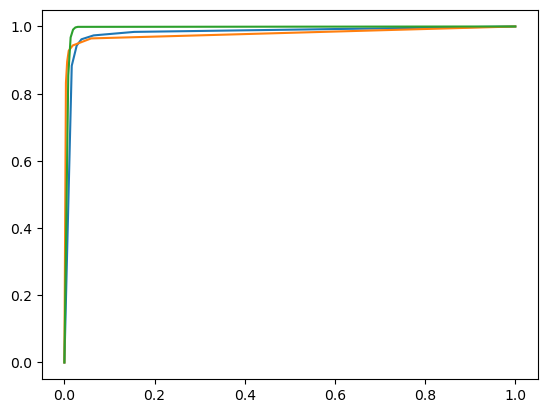

In [67]:
evaluate_model(KNeighborsClassifier(), train, t)
# było 0.9618095238095238

Model klasyfikacji KNN osiągnął ogólną dokładność na poziomie 96.15%. Z raportu klasyfikacji wynika, że model dobrze radzi sobie z klasyfikacją obiektów GALAXY oraz QSO, uzyskując odpowiednio 97% i 96% precyzji. Jednakże, dla klasy QSO (kwazarów) precyzja jest nieco niższa - 96%, co sugeruje, że model może mieć trudności w identyfikacji tej klasy.

Analiza macierzy pomyłek pokazuje, że model często myli klasy GALAXY z QSO, co może wymagać dalszej optymalizacji.

Średnie AUC dla każdej klasy oraz Gini coefficient wskazują, że model ma ogólnie dobrą zdolność do rozróżniania klas, z wynikami powyżej 0.95 dla każdej klasy.

### Model 2 - RandomForestClassifier

Dokładność całkowita (Accuracy): 0.9636666666666667

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.96      0.97      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.96     21000
weighted avg       0.96      0.96      0.96     21000


Confusion matrix:
[[12257   172   109]
 [  283  3689     1]
 [  198     0  4291]]
AUC dla klasy GALAXY: 0.9891728577881453
Gini dla klasy GALAXY: 0.9783457155762907
 
AUC dla klasy QSO: 0.9882980970792292
Gini dla klasy QSO: 0.9765961941584584
 
AUC dla klasy STAR: 0.9975629024678377
Gini dla klasy STAR: 0.9951258049356755
 
Średni AUC: 0.9916779524450708
Gini coefficient: 0.9833559048901417


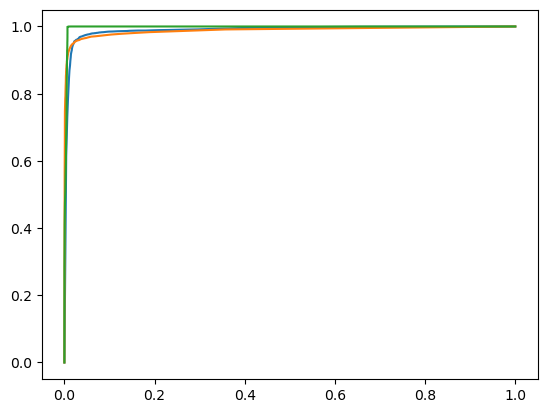

In [68]:
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), train, t)
# 0.963

Model RandomForestClassifier osiągnął nieznacznie wyższą dokładność całkowitą w porównaniu do modelu KNN.
Wartości AUC dla klasy GALAXY i QSO są nieznacznie wyższe w przypadku drugiego modelu, podczas gdy dla klasy STAR wartość AUC jest zbliżona. Oznacza to, że RandomForestClassifier model ma lepszą zdolność do rozróżniania poszczególnych klas niż KNN

### Model 3 xboost

In [69]:
evaluate_model(XGBClassifier(n_estimators=100, random_state=42), train, t, 2)
# 0.9556190476190476

Dokładność całkowita (Accuracy): 0.9535238095238096

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12538
           1       0.95      0.93      0.94      3973
           2       0.97      0.91      0.94      4489

    accuracy                           0.95     21000
   macro avg       0.96      0.94      0.95     21000
weighted avg       0.95      0.95      0.95     21000


Confusion matrix:
[[12243   188   107]
 [  286  3686     1]
 [  393     1  4095]]
AUC dla klasy GALAXY: 0.9888218756130029
Gini dla klasy GALAXY: 0.9776437512260059
 
AUC dla klasy QSO: 0.9922263792965234
Gini dla klasy QSO: 0.9844527585930467
 
AUC dla klasy STAR: 0.9966394208339394
Gini dla klasy STAR: 0.9932788416678788
 
Średni AUC: 0.9925625585811552
Gini coefficient: 0.9851251171623103
AUC dla klasy GALAXY: 0.9888218756130029
Gini dla klasy GALAXY: 0.9776437512260059
 
AUC dla klasy QSO: 0.9922263792965234
Gini dla klasy QSO: 0.9844

Model XGBoost poprawnie sklasyfikował 95.3% wszystkich próbek. Model osiągnął wysokie wartości precision dla wszystkich klas, co oznacza, że dobrze radził sobie zarówno z minimalizacją fałszywie pozytywnych jak i fałszywie negatywnych przypadków.
Model poprawnie zidentyfikował większość przypadków dla wszystkich klas, najwięcej błędów pojawiło się z klasyfikacją star i galaxy - model przewidział błędnie 400 razy klasę galaxy zamiast star.

### Model 4 Gradient Boosting

Dokładność całkowita (Accuracy): 0.9657142857142857

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.96      0.91      0.94      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000


Confusion matrix:
[[12277   152   109]
 [  341  3631     1]
 [  116     1  4372]]
AUC dla klasy GALAXY: 0.9888759961256423
Gini dla klasy GALAXY: 0.9777519922512845
 
AUC dla klasy QSO: 0.9912489781150503
Gini dla klasy QSO: 0.9824979562301006
 
AUC dla klasy STAR: 0.9963068425096191
Gini dla klasy STAR: 0.9926136850192382
 
Średni AUC: 0.9921439389167706
Gini coefficient: 0.9842878778335411


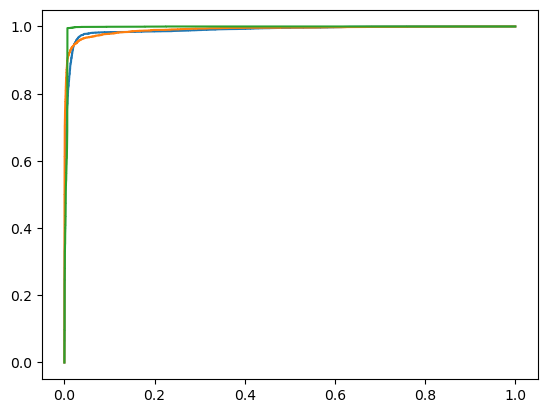

In [70]:
evaluate_model(GradientBoostingClassifier(n_estimators=100, random_state=42), train, t)
# 0.9656666666666667

Model Gradient Boosting poprawnie sklasyfikował 96.6% wszystkich próbek.
Macierz pomyłek pokazuje, że model poprawnie rozróżnia klasy star i quasar (tylko jeden błąd)!

Podsumowując, zarówno model XGBoost, jak i Gradient Boosting wykazały się bardzo dobrymi wynikami, osiągając wysoką dokładność oraz skuteczność w klasyfikacji danych.

### Model 5: Regresja logistyczna

Dokładność całkowita (Accuracy): 0.9532380952380952

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.94      0.88      0.91      3973
        STAR       0.94      1.00      0.97      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000


Confusion matrix:
[[12054   205   279]
 [  491  3479     3]
 [    0     4  4485]]
AUC dla klasy GALAXY: 0.9830761895796128
Gini dla klasy GALAXY: 0.9661523791592257
 
AUC dla klasy QSO: 0.9850521974168416
Gini dla klasy QSO: 0.9701043948336832
 
AUC dla klasy STAR: 0.9955970542546151
Gini dla klasy STAR: 0.9911941085092302
 
Średni AUC: 0.9879084804170232
Gini coefficient: 0.9758169608340463


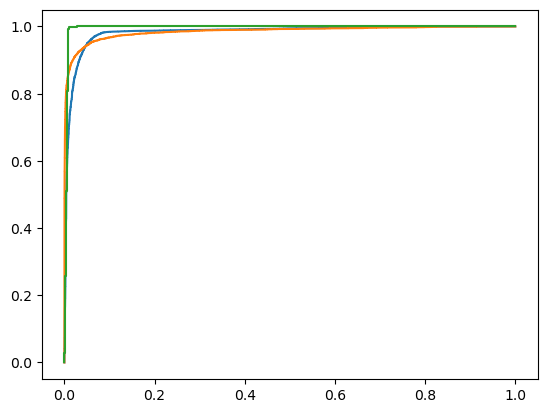

In [71]:
evaluate_model(LogisticRegression(max_iter=1000, random_state=42), train, t)
# 0.9535238095238096

Model regresji logistycznej ma nieco niższą dokładność niż modele XGBoost i Gradient Boosting. Na razie najlepiej przewiduje klasę Star - prawie brak pomyłek w klasyfikowaniu star i quasar oraz nie zakwalifikował błędnie żadnej gwiazdy do galaktyki!

### Model 6: Model Markova

In [72]:
evaluate_model(ClassifierChain(base_estimator=DecisionTreeClassifier(), order='random', random_state=42), train, t, 3)
# 0.9088095238095238

Dokładność całkowita (Accuracy): 0.9130952380952381

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12538
           1       0.77      0.92      0.84      3973
           2       0.97      0.78      0.87      4489

   micro avg       0.91      0.91      0.91     21000
   macro avg       0.90      0.89      0.89     21000
weighted avg       0.92      0.91      0.91     21000
 samples avg       0.91      0.91      0.91     21000

AUC dla klasy 0: 0.9417202288828301
Gini dla klasy 0: 0.8834404577656603
 
AUC dla klasy 1: 0.9259582850240178
Gini dla klasy 1: 0.8519165700480356
 
AUC dla klasy 2: 0.8893450863589877
Gini dla klasy 2: 0.7786901727179754
 
Średni AUC: 0.9190078667552785
Gini coefficient: 0.8380157335105569


Model Markov Chain osiąga dobre wyniki, jednak w porówaniu z posostałymi modelami nie jest aż tak efektywny

### Model 7 Adaptacyjne drzewa decyzyjne

Dokładność całkowita (Accuracy): 0.909952380952381

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.95      0.96      0.95     12538
         QSO       0.77      0.92      0.84      3973
        STAR       0.97      0.77      0.86      4489

    accuracy                           0.91     21000
   macro avg       0.90      0.88      0.88     21000
weighted avg       0.92      0.91      0.91     21000


Confusion matrix:
[[12029   409   100]
 [  332  3640     1]
 [  363   686  3440]]
AUC dla klasy GALAXY: 0.9386357649535768
Gini dla klasy GALAXY: 0.8772715299071536
 
AUC dla klasy QSO: 0.925937308878153
Gini dla klasy QSO: 0.8518746177563059
 
AUC dla klasy STAR: 0.8801002656862321
Gini dla klasy STAR: 0.7602005313724642
 
Średni AUC: 0.9148911131726539
Gini coefficient: 0.8297822263453078


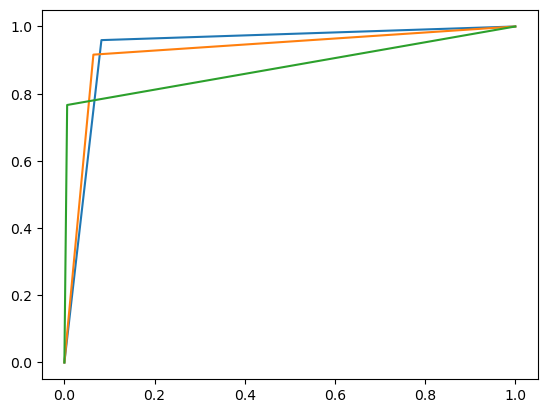

In [73]:
evaluate_model(DecisionTreeClassifier(), train, t)
# 0.8979047619047619

Model DecisionTreeClassifier osiąga gorsze wyniki niż np. regresja logistyczna czy xgboost. Bardzo słabo przewiduje klasę STAR, co jest atutem pozostałych modeli.

## Wnioski:

1) najwyższa dokładność ogólna: knn, randomForest, gradient boosting ~ 0.96


2) najwyższa dokładność:


        dla Star: randomForest, gradient boosting ~ 0.98
        
        dla Galaxy: knn ~ 0.97
        
        dla Quasar: knn, gradient boosting ~ 0.96
        
        
3) najwyższy średni auc: gradient, boosting, xboost, randomForest  ~ 0.99


4) najwyższy auc:

        dla Star: wszystkie oprócz Markowa i DecisionTreeClassifier ~ 0.99
        
        dla Galaxy: wszystkie oprócz Markowa i DecisionTreeClassifier ~ 0.99
        
        dla Quasar: xboost, gradient boosting ~ 0.99


najsłabiej sobie radzi Model Markova

Decision Tree Classifier bardzo słabo przewiduję klasę STAR, dla każdego innego modelu predykcyjność STAR jest najwyższa, często bliska 100 %

## Strojenie hiperparametrów dla wybranych modeli, wybór najlepszego

#### Do kolejnej części wybrano te modele, które osiągnęły najlepsze wyniki z standardowymi, niezmienionymi parametrami. Są to:

1) XGBoost

2) Random Forest Classifier

3) Logistic Regression ????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????

In [14]:
### strojenie parametrów forest

In [15]:
def hiperparams_forest(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    rf_clf = RandomForestClassifier()

    # Definicja siatki parametrów do przeszukania
    param_grid = {
        'n_estimators': [50, 100, 150],  # Liczba drzew w lesie
        'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
        'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła
        'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek wymagana do utworzenia liścia
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_rf_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_rf_clf.predict(test_data)
    
    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    
    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_rf_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")
    

    return best_rf_clf, classification_rep, conf_matrix, mean_auc, mean_gini

In [16]:
best_rf_clf_forest, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest = hiperparams_forest(train_data, train_target, test_data, test_target)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Najlepsze parametry: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Dokładność: 0.9687619047619047
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.98      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12262   166   110]
 [  282  3690     1]
 [   97     0  4392]]
AUC dla klasy 'GALAXY': 0.9905461493019622
Gini dla klasy 'GALAXY': 0.9810922986039243
AUC dla klasy 'QSO': 0.9903526654805412
Gini dla klasy 'QSO': 0.9807053309610825
AUC dla klasy 'STAR': 0.9977462253068521
Gini dla klasy 'STAR': 0.9954924506137042
Średnie AUC: 0.9928816800297852
Średni Gini: 0.9857633600595704

In [19]:
def hiperparams_xgboost(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Definicja modelu XGBoost
    xgb_clf = XGBClassifier()

    # Definicja siatki parametrów do przeszukania 
    param_grid = {
        'max_depth': [3, 6, 9],  # Maksymalna głębokość drzewa
        'learning_rate': [0.1, 0.3],  # Współczynnik uczenia
        'n_estimators': [50, 100],  # Liczba drzew
        'subsample': [0.8, 1.0],  # Procent próbek używanych do trenowania każdego drzewa
        'colsample_bytree': [0.8, 1.0],  # Procent kolumn używanych do trenowania każdego drzewa
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Dopasowanie modelu do danych treningowych
    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_xgb_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_xgb_clf.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

     # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_xgb_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")

    return best_xgb_clf, accuracy, classification_rep, conf_matrix, mean_auc, mean_gini


In [22]:
best_rf_clf_xgboost, classification_rep_xgboost, conf_matrix_xgboost, mean_auc_xgboost, mean_gini_xgboost = hiperparams_xgboost(train_data, train_target, test_data, test_target)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Najlepsze parametry: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Dokładność: 0.953952380952381
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.95      0.98      0.96     12538
         QSO       0.96      0.92      0.94      3973
        STAR       0.97      0.91      0.94      4489

    accuracy                           0.95     21000
   macro avg       0.96      0.94      0.95     21000
weighted avg       0.95      0.95      0.95     21000

Confusion Matrix:
[[12266   163   109]
 [  301  3671     1]
 [  393     0  4096]]
AUC dla klasy 'GALAXY': 0.9896100020437986
Gini dla klasy 'GALAXY': 0.9792200040875971
AUC dla klasy 'QSO': 0.9918017416882687
Gini dla klasy 'QSO': 0.9836034833765375
AUC dla klasy 'STAR': 0.9971253697100534
Gini dla klasy 'STAR': 0.9942507394201068
Średnie AUC: 0.992845704480707
Średni Gini: 0.985

ValueError: too many values to unpack (expected 5)

In [ ]:
# gradint boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def hiperparams_gradient_boosting(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Definicja modelu Gradient Boosting
    gb_clf = GradientBoostingClassifier()

    # Definicja siatki parametrów do przeszukania
    param_grid = {
        'learning_rate': [0.1, 0.3],  # Współczynnik uczenia
        'n_estimators': [50, 100],  # Liczba estymatorów
        'max_depth': [3, 6],  # Maksymalna głębokość drzewa
        'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła
        'min_samples_leaf': [1, 2],  # Minimalna liczba próbek wymagana do utworzenia liścia
        'subsample': [0.8, 1.0],  # Procent próbek używanych do trenowania każdego estymatora
        'max_features': ['sqrt', 'log2']  # Maksymalna liczba cech branych pod uwagę przy podziale węzła
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Dopasowanie modelu do danych treningowych
    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_gb_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_gb_clf.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_gb_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")

    return best_gb_clf, accuracy, classification_rep, conf_matrix, mean_auc, mean_gini


In [ ]:
best_gb_clf_gradient, accuracy_gradient, classification_rep_gradient, conf_matrix_gradient, mean_auc_gradient, mean_gini_gradient = hiperparams_gradient_boosting(train_data, train_target, test_data, test_target)

In [ ]:
def hiperparams_logistic_regression(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Definicja modelu regresji logistycznej
    lr_clf = LogisticRegression(max_iter=1000)

    # Definicja siatki parametrów do przeszukania
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],  # Parametr regularyzacji
        'penalty': ['l1', 'l2'],  # Rodzaj normy regularyzacji
        'solver': ['liblinear', 'saga'],  # Algorytm optymalizacji
        'class_weight': [None, 'balanced']  # Wagi klas
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Dopasowanie modelu do danych treningowych
    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_lr_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_lr_clf.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_lr_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")

    return best_lr_clf, accuracy, classification_rep, conf_matrix, mean_auc, mean_gini


In [ ]:
best_lr_clf_regression, accuracy_regression, classification_rep_regression, conf_matrix_regression, mean_auc_regression, mean_gini_regression = hiperparams_logistic_regression(train_data, train_target, test_data, test_target)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb

def ensemble_model(train_data, train_target, test_data, test_target):
    # Definicja modeli
    xgb_clf = xgb.XGBClassifier()
    rf_clf = RandomForestClassifier()
    lr_clf = LogisticRegression()

    # Definicja modelu ensemble
    ensemble_model = VotingClassifier(estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('lr', lr_clf)
    ], voting='hard')

    # Dopasowanie modelu do danych treningowych
    ensemble_model.fit(train_data, train_target)

    # Predykcja na danych testowych
    predictions = ensemble_model.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    classification_rep = classification_report(test_target, predictions)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    return ensemble_model, accuracy, classification_rep, conf_matrix

# Przykładowe wywołanie
ensemble_model, accuracy, classification_rep, conf_matrix = ensemble_model(train_data, train_target, test_data, test_target)


ensemble model - połączenie forest, xgb oraz regression

In [ ]:
def ensemble_model(train_data, train_target, test_data, test_target):
    # Definicja modeli
    xgb_clf = xgb.XGBClassifier()
    rf_clf = RandomForestClassifier()
    lr_clf = LogisticRegression()

    # Definicja modelu ensemble
    ensemble_model = VotingClassifier(estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('lr', lr_clf)
    ], voting='hard')

    # Dopasowanie modelu do danych treningowych
    ensemble_model.fit(train_data, train_target)

    # Predykcja na danych testowych
    predictions = ensemble_model.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    classification_rep = classification_report(test_target, predictions)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    return ensemble_model, accuracy, classification_rep, conf_matrix

# Przykładowe wywołanie
ensemble_model, accuracy, classification_rep, conf_matrix = ensemble_model(train_data, train_target, test_data, test_target)
